In [42]:
%pylab inline
import numpy as np
import torch
import os
import pandas as pd

from torch import nn
from torch import optim
from torch.nn import functional as F
from torch import autograd
from torch.autograd import Variable
import nibabel as nib
from torch.utils.data.dataset import Dataset
from torch.utils.data import dataloader

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from nilearn import plotting
from ADNI_dataset import *
from BRATS_dataset import *
from ATLAS_dataset import *

import pytorch_ssim
from ipdb import set_trace

Populating the interactive namespace from numpy and matplotlib


/usr/local/miniconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['disp', 'Generator', 'resize', 'plotting', 'real']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Configuration

In [43]:
# used to store the MMD ans MS-SSIM
try:
    os.mkdir('./test_data')
except FileExistsError:
    pass
gpu = True
workers = 4
BATCH_SIZE = 8
latent_dim = 1000

Use_BRATS = False
Use_ATLAS = False

In [44]:
trainset = ADNIdataset(augmentation=True)
train_loader = torch.utils.data.DataLoader(trainset,batch_size=BATCH_SIZE,
                                          shuffle=True,num_workers=workers)
#'flair' or 't2' or 't1ce'
# trainset = BRATSdataset(imgtype='flair')
# train_loader = torch.utils.data.DataLoader(trainset,batch_size = BATCH_SIZE, shuffle=True,
#                                                num_workers=workers)

# trainset = ATLASdataset(augmentation=True)
# train_loader = torch.utils.data.DataLoader(trainset,batch_size=BATCH_SIZE,
#                                           shuffle=True,num_workers=workers)

def inf_train_gen(data_loader):
    while True:
        for _,images in enumerate(data_loader):
            yield images
gen_load = inf_train_gen(train_loader)

## Pre-trained Generator Load

In [45]:
#-------------------------------------------
#Choose the Model you want!
from Model_alphaWGAN import Generator
from Model_alphaWGAN import Discriminator
# from Model_alphaGAN import Generator
# from Model_VAEGAN import Generator
# from Model_WGAN import Generator
#-------------------------------------------

G = Generator(noise=1000).cuda()
E = Discriminator(out_class = latent_dim, is_dis=False)
#-----------------------
#Load Pre-trained model
#-----------------------

#------------Trained Model of ADNI dataset---------------------
G.load_state_dict(torch.load('./trained/G_iter12500.pth')) # Alpha-WGAN-GP
E.load_state_dict(torch.load('./trained/E_iter12500.pth')) # Alpha-WGAN-GP Encoder
# G.load_state_dict(torch.load('./trained/G_VG_iter24552.pth')) #VAE-GAN
# G.load_state_dict(torch.load('./checkpoint/Alpha_G.pth')) #Alpha-GAN
# G.load_state_dict(torch.load('./checkpoint/G_W_iter3000.pth')) #WGAN-GP

#------------Trained Model of ATLAS dataset---------------------
# G.load_state_dict(torch.load('./checkpoint/Ours_at_G.pth'))

#------------Trained Models of BRATS dataset---------------------
# G.load_state_dict(torch.load('./checkpoint/Ours_fl_G.pth'))
# G.load_state_dict(torch.load('./checkpoint/Ours_t2_G.pth'))

Fake Image - slice series visualization

You can change the axis (x , y , z ) by changing  display_mode = 'x' / 'y' / 'z'

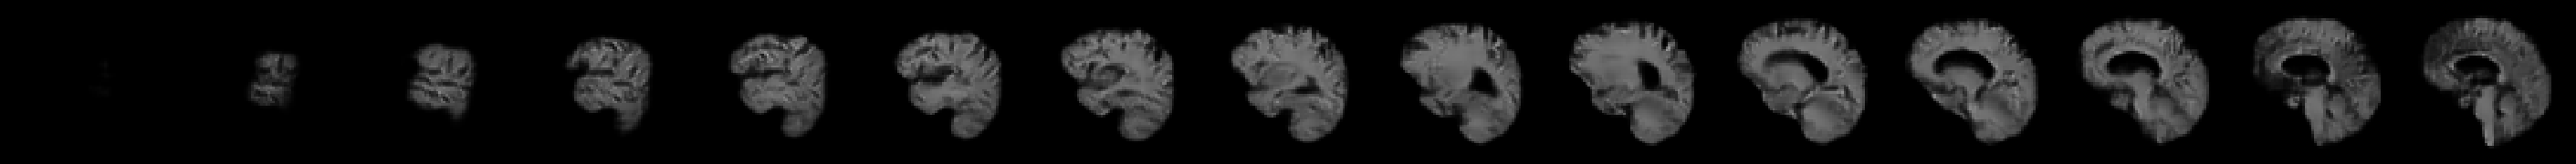

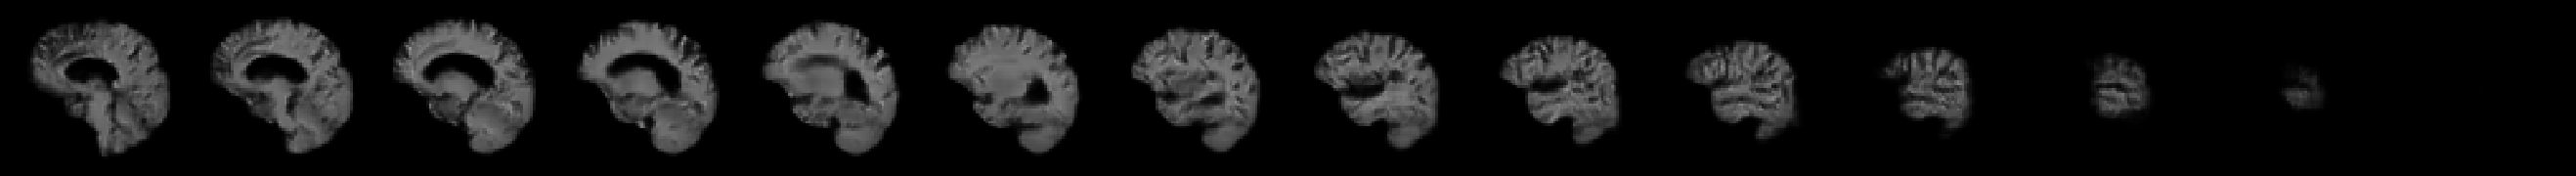

In [46]:
Show_color = False

noise = torch.randn(1, 1000).cuda()
fake_image = G(noise)
featmask = np.squeeze(fake_image[0].data.cpu().numpy())
featmask = nib.Nifti1Image(featmask,affine = np.eye(4))

arr1 = [4,6,8,10,12,14,16,18,20,22,24,26,28,30,32]
arr2 = [34,36,38,40,42,44,46,48,50,52,54,56,58,60]
if Show_color:
    disp = plotting.plot_img(featmask,cut_coords=arr1,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    # disp.annotate(size=25,left_right=False,positions=True)
    plotting.show()
    disp=plotting.plot_img(featmask,cut_coords=arr2,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    # disp.annotate(size=25,left_right=False)
    plotting.show()
else:
    disp = plotting.plot_anat(featmask,cut_coords=arr1,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    plotting.show()
    # disp.annotate(size=25,left_right=False)
    disp=plotting.plot_anat(featmask,cut_coords=arr2,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    # disp.annotate(size=25,left_right=False)
    plotting.show()

Fake Image - Center cut slices Visualization

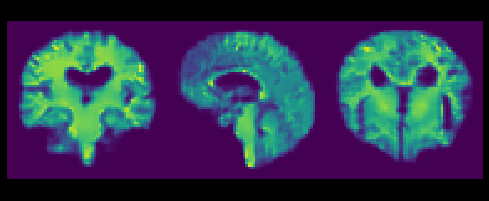

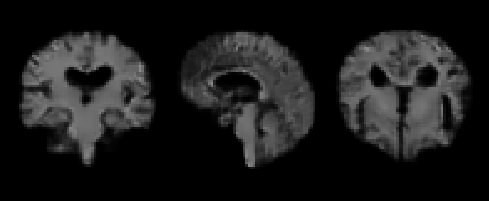

In [47]:
noise = Variable(torch.randn((1, 1000)).cuda())
# fake_image = G(noise)
featmask = np.squeeze(fake_image[0].data.cpu().numpy())
featmask = nib.Nifti1Image(featmask,affine = np.eye(4))
plotting.plot_img(featmask,cut_coords=(32,32,32),draw_cross=False,annotate=False,black_bg=True)
plotting.plot_anat(featmask,cut_coords=(32,32,32),draw_cross=False,annotate=False,black_bg=True)
plotting.show()

Real Image - Slice series visualization

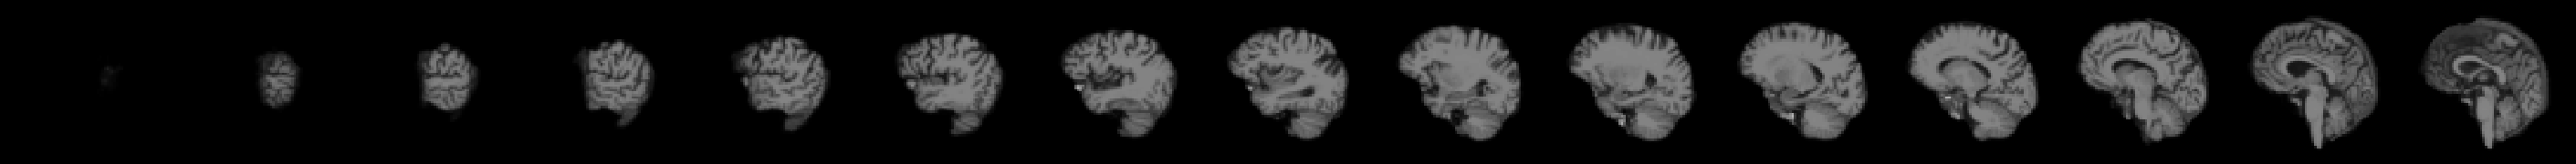

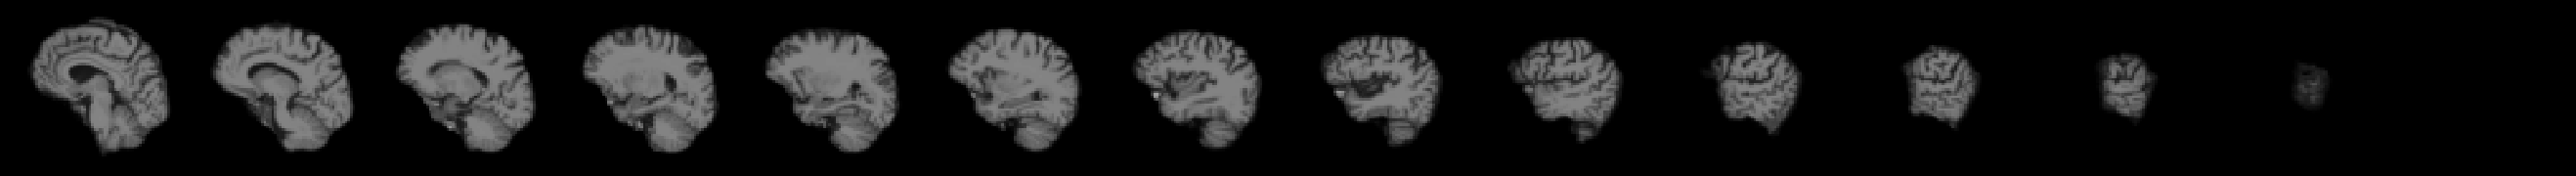

In [48]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size=2, shuffle=True, num_workers=workers)
gen_load = inf_train_gen(train_loader)

Show_color = False

image = gen_load.__next__()
featmask = np.squeeze(image[0].data.cpu().numpy())
featmask = nib.Nifti1Image(featmask,affine = np.eye(4))
arr1 = [4,6,8,10,12,14,16,18,20,22,24,26,28,30,32]
arr2 = [34,36,38,40,42,44,46,48,50,52,54,56,58,60]

if Show_color:
    disp = plotting.plot_img(featmask,cut_coords=arr1,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    # disp.annotate(size=25,left_right=False,positions=True)
    plotting.show()
    disp=plotting.plot_img(featmask,cut_coords=arr2,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    # disp.annotate(size=25,left_right=False)
    plotting.show()
else:
    disp = plotting.plot_anat(featmask,cut_coords=arr1,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    plotting.show()
    # disp.annotate(size=25,left_right=False)
    disp=plotting.plot_anat(featmask,cut_coords=arr2,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    # disp.annotate(size=25,left_right=False)
    plotting.show()

# MS-SSIM Calculation

In [38]:
# sum_ssim = 0
# for k in range(20):
#     for i,dat in enumerate(train_loader):
#         if len(dat)!=2:
#             break
#         img1 = dat[0]
#         img2 = dat[1]

#         msssim = pytorch_ssim.msssim_3d(img1,img2)
#         sum_ssim = sum_ssim+msssim
#     print(sum_ssim/((k+1)*(i+1)))

In [39]:
sum_ssim = 0
for i in range(1000):
    noise = Variable(torch.randn((2, 1000)).cuda())
    fake_image = G(noise)

    img1 = fake_image[0]
    img2 = fake_image[1]

    msssim = pytorch_ssim.msssim_3d(img1,img2)
    sum_ssim = sum_ssim+msssim
    if i % 100 == 0:
        print(sum_ssim/1000)
print(sum_ssim/1000)

tensor(0.0008, device='cuda:0')


KeyboardInterrupt: 

# MS-SSIM for real images

In [ ]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size=2, shuffle=True, num_workers=workers)
test_loader = inf_train_gen(train_loader)
i = 0
sum_ssim = 0
while i < 494:
    img1, img2 = test_loader.__next__()
    msssim = pytorch_ssim.msssim_3d(img1,img2)
    sum_ssim = sum_ssim+msssim
    i += 1
    if i % 100 == 0:
        print(i, sum_ssim/ (494 * 2))
        
train_loader = torch.utils.data.DataLoader(trainset, batch_size=2, shuffle=True, num_workers=workers)
test_loader = inf_train_gen(train_loader)
while i < 494 * 2:
    img1, img2 = test_loader.__next__()
    msssim = pytorch_ssim.msssim_3d(img1,img2)
    sum_ssim = sum_ssim+msssim
    i += 1
    if i % 100 == 0:
        print(i, sum_ssim/ (494 * 2))
print(sum_ssim/(494 * 2))

# Maximum-Mean Discrepancy Score

In [ ]:
# read csv if exists
if os.path.exists('./test_data/mmd.csv'):
    # get the latest index
    df = pd.read_csv('./test_data/mmd.csv')
    start = int(df.iloc[-1]['index'])
else:
    df = pd.DataFrame({'index': [], 'mmd_score': []})
    start = 0 

for p in G.parameters():
    p.requires_grad = False
for s in range(start, 100):
    distmean = 0.0
    for i,(y) in enumerate(train_loader):
        y = Variable(y).cuda()
        noise = Variable(torch.randn((y.size(0), 1000)).cuda())
        x = G(noise)
        B = y.size(0)
        x = x.view(x.size(0), x.size(2) * x.size(3)*x.size(4))
        y = y.view(y.size(0), y.size(2) * y.size(3)*y.size(4))

        xx, yy, zz = torch.mm(x,x.t()), torch.mm(y,y.t()), torch.mm(x,y.t())

        beta = (1./(B*B))
        gamma = (2./(B*B)) 

        Dist = beta * (torch.sum(xx)+torch.sum(yy)) - gamma * torch.sum(zz)
        distmean += Dist

    mean = (distmean/(i+1)).item()
    print(f'\nCount: {s} Mean: {mean}')
    # write scores to csv
    df = df.append(pd.DataFrame({
        'index': [s],
        'mmd_score': [mean]
    }))
    df.to_csv('./test_data/mmd.csv', index=False)

meanarr = numpy.array(df.iloc[:]['mmd_score'].tolist())
print('Total_mean:'+str(np.mean(meanarr))+' STD:'+str(np.std(meanarr)))


Count: 0 Mean: 3115.986328125

Count: 1 Mean: 3086.830810546875

Count: 2 Mean: 3101.710205078125

Count: 3 Mean: 3085.4453125

Count: 4 Mean: 3082.570068359375

Count: 5 Mean: 3123.682373046875

Count: 6 Mean: 3074.94970703125

Count: 7 Mean: 3119.409912109375

Count: 8 Mean: 3087.893310546875

Count: 9 Mean: 3068.075927734375

Count: 10 Mean: 3033.6611328125

Count: 11 Mean: 3108.868896484375

Count: 12 Mean: 3075.94287109375

Count: 13 Mean: 3045.53076171875

Count: 14 Mean: 3100.96240234375

Count: 15 Mean: 3092.798828125

Count: 16 Mean: 3096.58203125

Count: 17 Mean: 3046.48486328125

Count: 18 Mean: 3076.31982421875

Count: 19 Mean: 3099.12744140625

Count: 20 Mean: 3048.48486328125

Count: 21 Mean: 3130.109130859375

Count: 22 Mean: 3072.259765625

Count: 23 Mean: 3131.208251953125

Count: 24 Mean: 3114.412353515625

Count: 25 Mean: 3097.654296875

Count: 26 Mean: 3063.793701171875

Count: 27 Mean: 3071.0048828125

Count: 28 Mean: 3112.309814453125

Count: 29 Mean: 3059.981201

### calculate mmd

In [20]:
df = pd.read_csv('./test_data/mmd.csv')
mmds = np.array(df.iloc[:]['mmd_score'].to_list())
mmds.mean()

3082.9251098632812

### visualize loss

In [ ]:
df = pd.read_csv('./trained/VAE_loss.csv')
y_arr = df.iloc[:]['loss:'].to_list()
x_arr = [i * 248 for i in range(len(y_arr))]
plt.xlabel('iteration')
plt.ylabel('loss')
plt.plot(x_arr, y_arr)
plt.show()

In [ ]:
ind_arr = df.iloc[:]['index'].to_list()
[(ind_arr[i], x_arr[i]) for i in range(len(ind_arr))]

### Images PCA Visualization

In [49]:
sample_df = pd.DataFrame()
real_df = pd.DataFrame()

train_loader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=True, num_workers=workers)
gen_load = inf_train_gen(train_loader)

for s in range(512):
    noise = torch.randn((1, 1000)).cuda()
    fake = np.squeeze(G(noise)).view(1, -1)
    sample_df = sample_df.append(pd.DataFrame(fake.cpu().detach().numpy()))
    
    real = np.squeeze(gen_load.__next__()).view(1, -1)
    real_df = real_df.append(pd.DataFrame(real.cpu().detach().numpy()))
    print(s, end=' ')

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

In [ ]:
# PCA of fake images
pca = PCA(n_components=2)
samples = StandardScaler().fit_transform(sample_df)
PCs = pca.fit_transform(sample_df)
plt.scatter(PCs[:, 0], PCs[:, 1])

# PCA of real images
reals = StandardScaler().fit_transform(real_df)
real_PCs = pca.fit_transform(real_df)
plt.scatter(real_PCs[:, 0], real_PCs[:, 1])

plt.show()